In [1]:
#Code adapted from https://github.com/TeaPearce/Bayesian_NN_Ensembles

import matplotlib.pyplot as plt
import numpy as np
import torch

import torch.nn as nn

In [59]:
# NN options
prior_scale_std=2.
data_noise_std = 0.01 # estimated noise variance
L=[100]   # Layers  
n_output=20
mid_act= nn.ReLU() #Activation function to use

# optimisation options
epochs = 1000 
l_rate = 0.01

n_data = 6 #Number of data points


In [60]:
data_noise = data_noise_std**2
prior_scale=prior_scale_std**2
W_var=[]   # Prior Variance for the weights between each layer. 

n_input=1
for n_hidden in L:
    W_var.append(prior_scale/n_input)
    n_input=n_hidden
W_var.append(prior_scale/n_input)

W_lambda=[data_noise/w for w in W_var]    # The weight decay

In [61]:
class model(nn.Module):
    def __init__(self, n_inputs=1, n_outputs=20, hiddens=[100,100]):
        super().__init__()

        layers = []
        for hidden in hiddens:
            layers.append(nn.Linear(n_inputs, hidden))
            layers.append(mid_act)
            n_inputs = hidden

        if n_outputs is not None:
            layers.append(nn.Linear(hidden, n_outputs,bias=False))

        self.layers = nn.Sequential(*layers)
            
    def forward(self, obs):
        return self.layers(obs)


In [62]:
def fn_make_data():
    # create some data[1., 4.5, 5.1, 6., 8., 9.]
    
    x_train = np.atleast_2d([1., 4.5, 5.1, 6., 8., 9.]).T
    x_train = x_train/5. - 1
    y_train = x_train * np.sin(x_train*5.)
    
    # create validation data - here we'll just a 1-d grid
    x_val = np.atleast_2d(np.linspace(-3, 3, 100)).T
    y_val = np.expand_dims(x_val[:,0],1) # just dummy data
    
    return x_train, y_train, x_val, y_val

In [63]:
def fn_make_NN(activation_in='relu'):
    # input and output dimension
    NN=model(1,n_output,L)
    
    for i in range(len(L)):
        NN.layers[2*i].weight.data.normal_(0.0, np.sqrt(W_var[i]))
        NN.layers[2*i].bias.data.normal_(0.0, np.sqrt(W_var[i]))
    
    NN.layers[2*len(L)].weight.data.normal_(0.0, np.sqrt(W_var[-1]))
    return NN

def fn_predict_ensemble(NN, x_test):
    ''' fn to predict given a list of NNs (an ensemble)''' 
    y_preds = []

    y_preds=NN(torch.tensor(x_test).float()).data.numpy()
    y_preds = np.array(y_preds)
    
    y_preds_mu =[]
    y_preds_std=[]
    
    for i in range(len(x_test)):
        y_preds_mu.append(y_preds[i].mean())
        y_preds_std.append(y_preds[i].std())
        
    return y_preds, y_preds_mu, y_preds_std

In [64]:
# create some data
x_train, y_train, x_test, y_test = fn_make_data()
x = torch.tensor(x_train).float()
y = torch.tensor(y_train).float()


# create the NN

NN=fn_make_NN()

In [65]:
# do training
NNs_hist_train=[]

# set up loss
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(NN.parameters(), lr=l_rate)
    
# set anchoring points (different set for each NN)

W=[]  # for weights
B=[]  # for bias
n_inputs=1
for i in range(len(L)):
    # set anchoring points (different set for each NN)
    n_hidden=L[i]
    W_anc = np.random.normal(loc=0,scale=np.sqrt(W_var[i]),size=[n_hidden,n_inputs])
    b_anc = np.random.normal(loc=0,scale=np.sqrt(W_var[i]),size=[n_hidden])
    W_anc = torch.tensor(W_anc).float()
    b_anc = torch.tensor(b_anc).float()
    W.append(W_anc)
    B.append(b_anc)     
    n_inputs=n_hidden
W_last_anc = np.random.normal(loc=0,scale=np.sqrt(W_var[-1]),size=[n_output,n_inputs])
W_last_anc = torch.tensor(W_last_anc).float()
W.append(W_last_anc)
    

    
NNs_losses=[]
for _ in range(epochs):
        
    y_pred = NN(x)
    l1=0
        
    for i in range(len(x_train)):
                          
        l1+=((y_pred[i]-y[i].item())**2).sum()
        
    loss =l1

    #print(l1)    
    # set up reg loss
    l2 = 0
    for i in range(len(L)):
                l2 += W_lambda[i]/n_data * torch.mul(NN.layers[2*i].weight - W[i], NN.layers[2*i].weight - W[i]).sum()
                l2 += W_lambda[i]/n_data * torch.mul(NN.layers[2*i].bias - B[i], NN.layers[2*i].bias - B[i]).sum()
                
    l2 += W_lambda[-1]/n_data * torch.mul(NN.layers[2*len(L)].weight - W[len(L)], NN.layers[2*len(L)].weight - W[len(L)]).sum()
        

       
    loss = loss + l2
        
    # run gradient update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    NNs_losses.append(loss.item())
NNs_hist_train.append(NNs_losses)

-7.295392


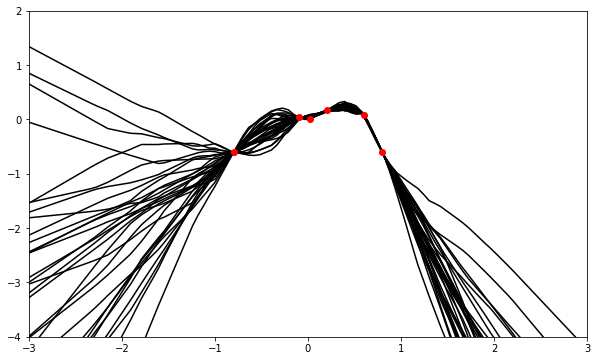

In [66]:
y_preds, y_preds_mu, y_preds_std = fn_predict_ensemble(NN,x_test)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for i in range(n_output):
    yy=[]
    for j in range(len(x_test)):
        yy.append(y_preds[j][i])
    ax.plot(x_test,yy,'k')
ax.plot(x_train,y_train,'ro')
ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)


print(y_preds[0][1] )

Text(0.5, 1.0, 'Multioutput, 100 Neurons')

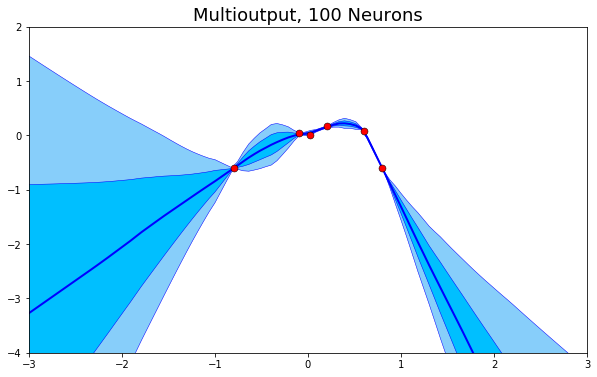

In [69]:
# add on data noise
y_preds_std = np.sqrt(np.square(y_preds_std)+data_noise )

# plot predictive distribution
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(x_test, y_preds_mu, 'b-', linewidth=2.,label=u'Prediction')
ax.plot(x_test, y_preds_mu + 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 2 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu + 1 * y_preds_std, 'b', linewidth=0.5)
ax.plot(x_test, y_preds_mu - 1 * y_preds_std, 'b', linewidth=0.5)
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 2 * y_preds_std,
                        (y_preds_mu + 2 * y_preds_std)[::-1]]),
         alpha=1, fc='lightskyblue', ec='None')
ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_preds_mu - 1 * y_preds_std,
                        (y_preds_mu + 1 * y_preds_std)[::-1]]),
         alpha=1, fc='deepskyblue', ec='None')

ax.plot(x_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k', markeredgewidth=0.5)
ax.set_ylim(-4, 2)
ax.set_xlim(-3, 3)
ax.set_title("Multioutput, 100 Neurons",fontsize=18)
